<a href="https://colab.research.google.com/github/altaga/Pytorch-Driving-Guardian/blob/main/Hardware%20Code/Jetson%20Code/YoloV3/YoloV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Blind Spot (YoloV3) Monitor:

Testing Module

In this section we are going to download all the necessary files directly from the repository to be able to carry out the model tests.

In [ ]:
# We create the temporary folders of the images and utilities.
!mkdir utils
!mkdir temp-img
# Model and utilities to carry out the conversion and application of the model.
!wget https://raw.githubusercontent.com/altaga/Pytorch-Driving-Guardian/main/Hardware%20Code/Jetson%20Code/YoloV3/utils/model.py
!wget https://raw.githubusercontent.com/altaga/Pytorch-Driving-Guardian/main/Hardware%20Code/Jetson%20Code/YoloV3/utils/datasets.py -O utils/datasets.py
!wget https://raw.githubusercontent.com/altaga/Pytorch-Driving-Guardian/main/Hardware%20Code/Jetson%20Code/YoloV3/utils/utils.py -O utils/utils.py
!wget https://raw.githubusercontent.com/altaga/Pytorch-Driving-Guardian/main/Hardware%20Code/Jetson%20Code/YoloV3/utils/parse_config.py -O utils/parse_config.py
!wget https://raw.githubusercontent.com/altaga/Pytorch-Driving-Guardian/main/Hardware%20Code/Jetson%20Code/YoloV3/utils/augmentations.py -O utils/augmentations.py
# YoloV3 Original Model Weights, configurations and labels
!wget -c https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/altaga/Pytorch-Driving-Guardian/main/Hardware%20Code/Jetson%20Code/YoloV3/data/coco.names
!wget https://raw.githubusercontent.com/altaga/Pytorch-Driving-Guardian/main/Hardware%20Code/Jetson%20Code/YoloV3/config/yolov3.cfg
# Test image.
!wget https://i.ibb.co/CmKjFdt/yolo.jpg -O temp-img/c1.png

Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
from model import *
from utils.utils import *
from utils.datasets import *
import os
from PIL import Image
import cv2
import math
from random import randrange
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

Pytorch Darknet Neural Network Architecture.

<img src="https://i.stack.imgur.com/js9wN.png">

Layers:

- Input Layer: This layer has an input of (416,416,3), receiving the data from a 416 px high and 416 px long image in color.
- ConvolutionDownsampling: This layer has the function of pooling the image and starting to generate the image filters.
- Dense Connection: This layer is a network of connected normal neurons, like any dense layer in a neural network.
- Spatial Pyramid Pooling: Given an 2D input Tensor, Temporal Pyramid Pooling divides the input in x stripes which extend through the height of the image and width of roughly (input_width / x). These stripes are then each pooled with max- or avg-pooling to calculate the output.
  - https://github.com/revidee/pytorch-pyramid-pooling
- Object Detection: The purpose of this layer is to finish determining the objects that are being observed in the image.



Set variables to get the distance of objects from the camera

In [ ]:
# Value 240 in person, only for testing, the real value for the streets is 70
objects=[240,220,120,50] #person:70, cars:220, motorcycle:120, dogs:50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up model and classes
model = Darknet("yolov3.cfg", img_size=416).to(device)
model.load_darknet_weights("yolov3.weights")
model.eval()  # Set in evaluation mode
classes = load_classes("coco.names")  # Extracts class labels from file

# Global variables 

distance=100000     #Seed distance
distancemem=100000  #Seed memory distance
labelmem=""
labelmod=""
pos=""
imag=""
imgs = []  # Stores image paths
img_detections = []  # Stores detections for each image index
i = randrange(10)

Setup the data loader and run once the model

Distance formula:

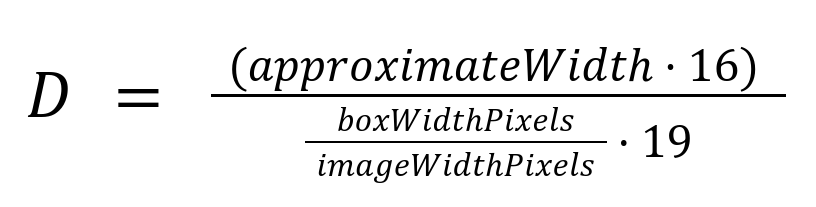


In [ ]:
# Pytorch Data loader for the model
dataloader = DataLoader(
    ImageFolder("temp-img", img_size=416),
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

for batch_i, (img_paths, input_imgs) in enumerate(dataloader):
    # Configure input
    input_imgs = Variable(input_imgs.type(Tensor))

    # Get detections
    with torch.no_grad():
        detections = model(input_imgs)
        detections = non_max_suppression(detections, 0.8, 0.4)

    imgs.extend(img_paths)
    img_detections.extend(detections)
    
# Iterate through images and save plot of detections
for img_i, (path, detections) in enumerate(zip(imgs, img_detections)):

    img = np.array(Image.open(path))
    imag = cv2.imread(path)
    (H, W) = imag.shape[:2]
    
    # Draw bounding boxes and labels of detections
    if detections is not None:
        # Rescale boxes to original image
        detections = rescale_boxes(detections, 416, img.shape[:2])
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            if(x1>5000 or y2>5000 or y1>5000 or x2>5000):
                # False Detection Low-Pass Filter
                break
            add=" "
            # Check if the object is Left or Right
            if((W/2)<(x1+((x2-x1)/2)).item()):
                pos="1"
                add=add+"left "
            else:
                pos="0"
                add=add+"right "
            i=0
            # Setup the label depend on detection.
            if(classes[int(cls_pred)]=="motorbike"):
                i=i+1
                check=objects[2]
                labelmem="m"+pos
            elif(classes[int(cls_pred)]=="dog"):
                i=i+2
                check=objects[3]
                labelmem="d"+pos
            elif(classes[int(cls_pred)]=="person"):
                i=i+3
                check=objects[0]
                labelmem="p"+pos
            elif(classes[int(cls_pred)]=="car"):
                i=i+4
                check=objects[1]
                labelmem="c"+pos
            else:
                i=i+5
                check = 1000000
            # Setup the label color
            COLORS1 = int(254 * abs(math.sin(i)))
            COLORS2 = int(254 * abs(math.sin(i+1)))
            COLORS3 = int(254 * abs(math.sin(i+2)))
            color= (COLORS1,COLORS2,COLORS3)
            # Calculate Distance formula.
            distance=(check*16)/(19*((x2.item()-x1.item())/W))
            if(distancemem>distance):
                if(300>distance):
                    distancemem=distance
                    labelmod = labelmem
                    add=add+"close "
            # Create a Rectangle patch
            cv2.rectangle(imag, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            cv2.putText(imag, classes[int(cls_pred)]+add,(int(x1), int(y1)-20), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 1, cv2.LINE_AA)
            cv2.imwrite("display.png",imag)

# Display the result
image = cv2.imread("display.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)